In [1]:

# Step I: Import all the dependencies

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
from F1tenth_utils import lift_states
from F1tenth_utils import plotter_tools_ol
from F1tenth_utils import simulate_ol
import importlib
importlib.reload(plotter_tools_ol)
importlib.reload(lift_states)
importlib.reload(simulate_ol)
import cvxpy as cp
from cvxpy import reshape
from cvxopt import matrix
from tqdm import tqdm
import time
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker




C:\Users\ajoglek\AppData\Local\Temp\ipykernel_28784\3883065228.py:5: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [2]:
## Step II: Loading data and models

# Load the data runs and select the trajectory to follow
data_run_path = 'Matrices_saved\Data_skidpad_ccw_unsync\\' # Path where the runs are stored
X_test = np.load(data_run_path+'X_train.npy', allow_pickle=True) # Snapshots of states
U_test = np.load(data_run_path+'U_train.npy', allow_pickle=True) #Snapshots of control inputs
with open(data_run_path+'fname','rb') as f:
    run_names = pickle.load(f) # Associated run names
print(run_names)

# Load model
EDMD_mat_path='Matrices_saved\Trained_models\\skidpad_ccw_unsync\\'
A_edmd_fro = np.load(EDMD_mat_path+'A_EDMD_fro.npy') #Lifted state matrix
B_edmd_fro = np.load(EDMD_mat_path + 'B_EDMD_fro.npy') # Control matrix
C_edmd = np.load(EDMD_mat_path + 'C_EDMD_fro.npy') # Output matrix

['skidpad_ccw_clean_v_0_5_d_0_312_filtered.mat', 'skidpad_ccw_clean_v_0_5_d_0_416_filtered.mat', 'skidpad_ccw_clean_v_0_5_d_0_520_filtered.mat', 'skidpad_ccw_clean_v_1_0_d_0_312_filtered.mat', 'skidpad_ccw_clean_v_1_0_d_0_416_filtered.mat', 'skidpad_ccw_clean_v_1_0_d_0_520_filtered.mat', 'skidpad_ccw_clean_v_1_5_d_0_312_filtered.mat', 'skidpad_ccw_clean_v_1_5_d_0_416_filtered.mat', 'skidpad_ccw_clean_v_1_5_d_0_520_filtered.mat', 'skidpad_ccw_clean_v_2_0_d_0_312_filtered.mat', 'skidpad_ccw_clean_v_2_0_d_0_416_filtered.mat', 'skidpad_ccw_clean_v_2_0_d_0_520_filtered.mat', 'skidpad_ccw_clean_v_2_5_d_0_312_filtered.mat', 'skidpad_ccw_clean_v_2_5_d_0_416_filtered.mat', 'skidpad_ccw_clean_v_2_5_d_0_520_filtered.mat']


Figure name not provided for save file


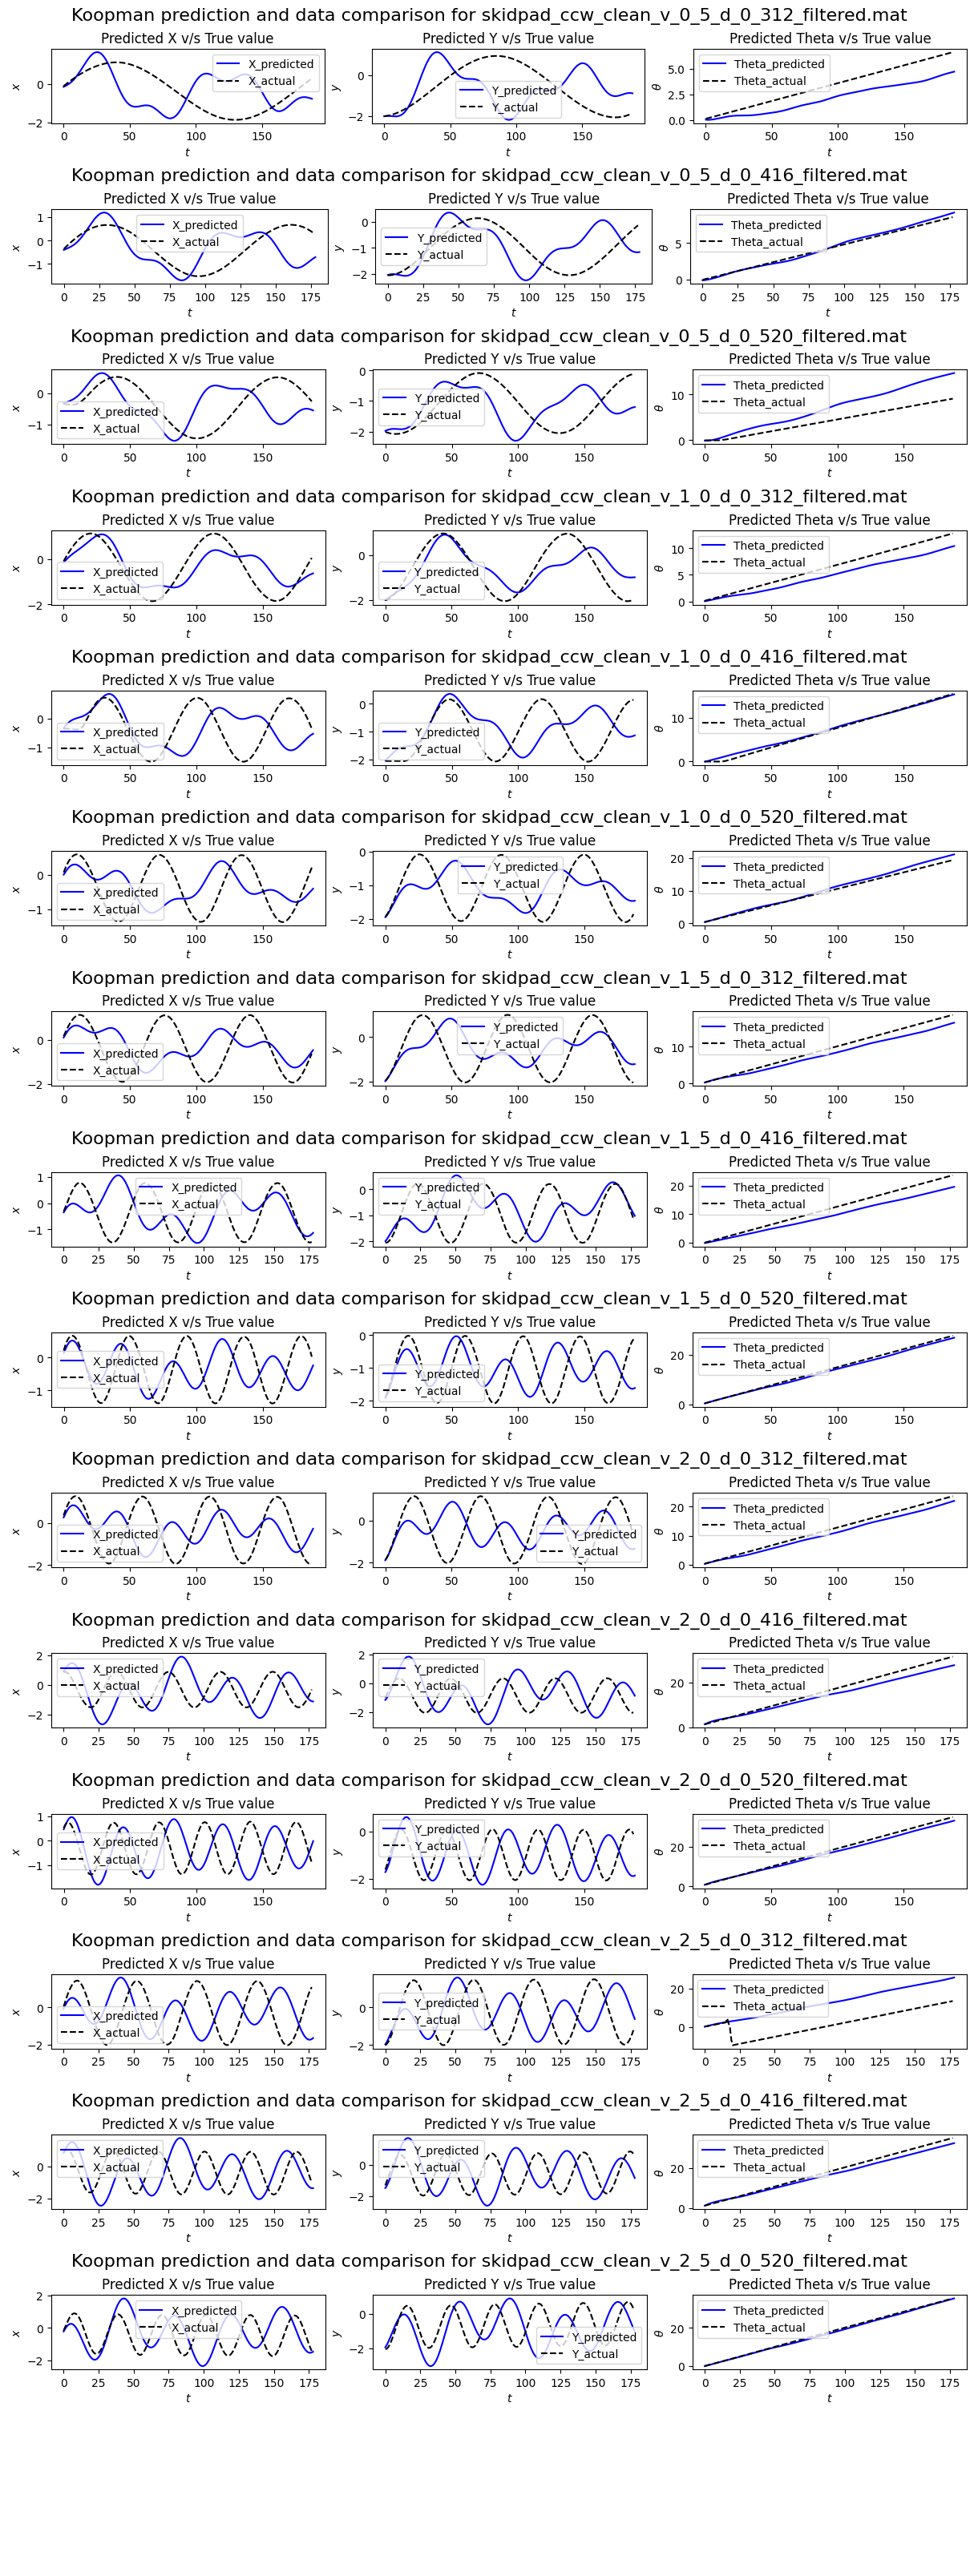

In [3]:
run_name = run_names
plotter_tools_ol.plot_lifted_predictions(X_test,A_edmd_fro,B_edmd_fro,U_test,run_name)

In [4]:
# Step III: Linear MPC with cvxpy

num = np.random.randint(0,len(X_test),1) # Randomly select any trajectory
num = [-4]
print(num,run_names[num[0]])

# Initialization
x_ref = X_test[num[0]] # Select  any trajectory from the dataset
z_ref = lift_states.lift_states(x_ref) #Lift the observation snapshots to functional space
u_ref = U_test[num[0]].T # Reference control for open-loop prediction plots
N = 65 # Prediction horizon

z_init = np.zeros((z_ref.shape[0],z_ref.shape[1])) # Init the realized trajectory
z_init[:, 0] = z_ref[:,0]
u_mpc = np.zeros((u_ref.shape[0],u_ref.shape[1])) # Stack of the control inputs generated by MPC


Q = np.zeros((z_ref.shape[0],z_ref.shape[0])) # Cost matrix for lifted states
R = np.eye(2) # Control cost
Q[1,1] = 1; Q[2,2] = 1; Q[3,3] = 1; Q[4,4] = 1
umin = np.array([0,-0.75]).reshape(2) # Control constraints
umax = np.array([3,0.75]).reshape(2) # Control constraints
count = 1
time_count = []

# Solve optimization till end of trajectory
for count in tqdm(range(1,z_ref.shape[1] - N),desc="Loading..."): # Main loop for solver
    z_pred = cp.Variable((z_ref.shape[0], N + 1))
    u_pred = cp.Variable((u_ref.shape[0], N))
    z_ref_ = matrix(z_ref[:,count:count+N+1]) # z_ref_ is the reference window for the current iteration of the loop
    u_ref_ = matrix(u_ref[:,count-1:count+N])
    cost = 0 # Initializing cost before the loop
    constr = [] # Initializing constraint value

    # constr = [z_pred[:, 0] == z_init[:,count-1]]
    for i in range(N):
        if i == 0:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
            constr += [z_pred[:, i + 1] == A_edmd_fro @ z_pred[:, i] + B_edmd_fro @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        else:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) \
                    # + cp.quad_form(reshape((u_pred[:,i]-u_pred[:,i-1])/0.5,(2,1)) ,np.eye(2)*5) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
            constr += [z_pred[:, i + 1] == A_edmd_fro @ z_pred[:, i] + B_edmd_fro @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]

    constr += [z_pred[:, 0] == z_init[:,count-1]] # Add initial constraints
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(solver=cp.SCS,verbose=False) # Solve the optimization problem with SCS solver
    u_mpc[:,count-1] = u_pred.value[:,0]
    z_init[:,count] = A_edmd_fro@z_init[:,count-1] + B_edmd_fro@u_pred.value[:,0]

#Get open loop response for comparison
x_hat_ol = simulate_ol.simulate_ol(A_edmd_fro,B_edmd_fro,C_edmd,X_test[num[0]],U_test[num[0]]) #Obtain open loop response

[-4] skidpad_ccw_clean_v_2_0_d_0_520_filtered.mat


Loading...: 100%|██████████| 123/123 [00:38<00:00,  3.16it/s]


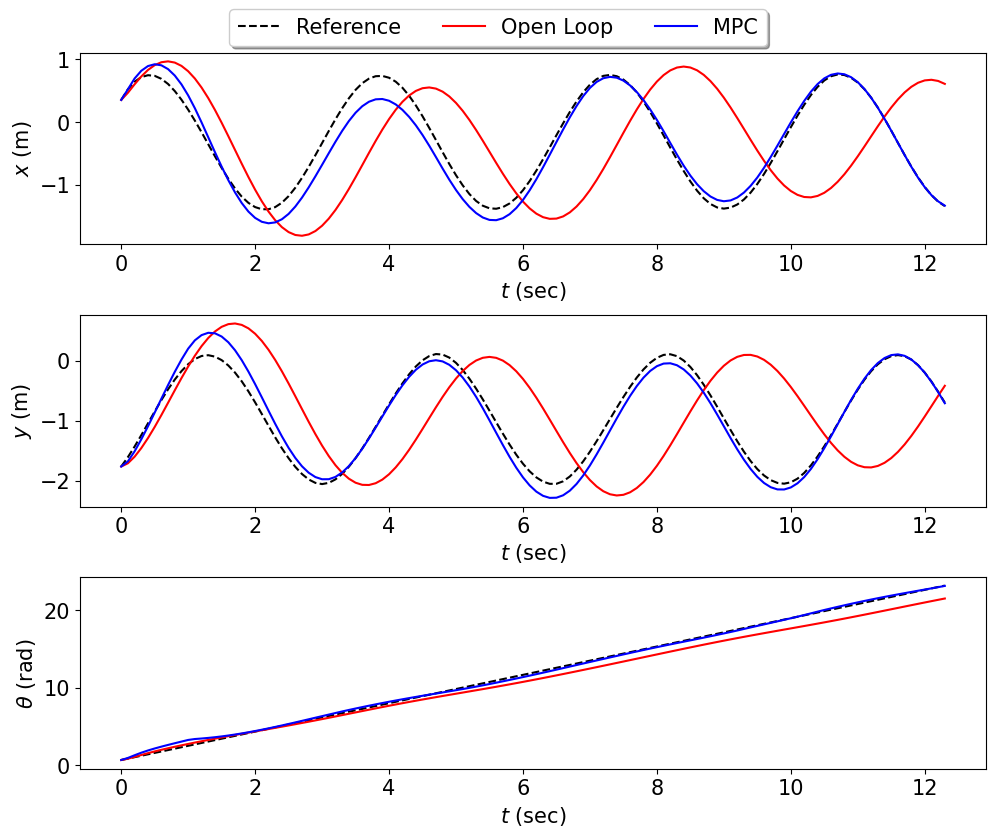

In [5]:
# Step IV: Plot and visualize results
save_fig = 'No'

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x_ts = np.arange(0, len(X_test[num[0]][:-N,0]),1)
x_ts = x_ts/10

#Plot all
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(10, 8))
axs[0].plot(x_ts,X_test[num[0]][:-N,0],'--k', label='x_ref')
axs[0].plot(x_ts,x_hat_ol[0,:-N],'r',label='X ol')
axs[0].plot(x_ts,z_init[1,:-N],'b',label='X ')

axs[0].set(ylabel=r'$x$ (m)',xlabel=r'$t$ (sec)')
axs[1].plot(x_ts,X_test[num[0]][:-N,1],'--k', label='Y actual')
axs[1].plot(x_ts,x_hat_ol[1,:-N],'r',label='Y ol')
axs[1].plot(x_ts,z_init[2,:-N],'b',label='Y mpc')
axs[1].set(ylabel=r'$y$ (m)',xlabel=r'$t$ (sec)')

axs[2].plot(x_ts,X_test[num[0]][:-N,3],'--k', label='Theta actual')
axs[2].plot(x_ts,x_hat_ol[3,:-N],'r',label='Theta ol')
axs[2].plot(x_ts,z_init[4,:-N],'b',label='Theta mpc')
axs[2].set(ylabel=r'$\theta$ (rad)',xlabel=r'$t$ (sec)')
fig.legend(['Reference','Open Loop','MPC'],loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True,)
file_name_strp = run_names[num[0]].split('.')
if save_fig == 'Yes':
    plt.savefig(file_name_strp[0]+'_plots', bbox_inches='tight')
    print('Figure_saved')
plt.show()

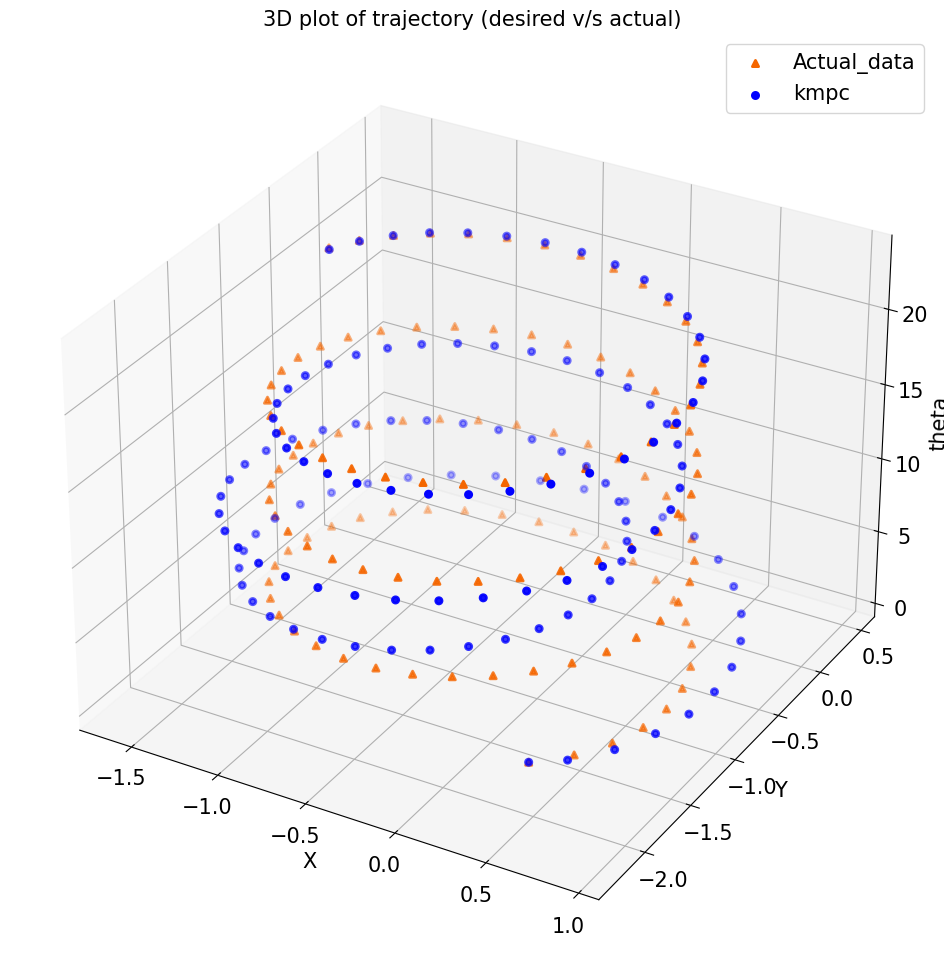

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(X_test[num[0]][:-N,0], X_test[num[0]][:-N,1], X_test[num[0]][:-N,3], lw=2, c='#f56600',marker='^', label='Original datapoints')
ax.scatter3D(z_init[1,:-N], z_init[2,:-N], z_init[4,:-N], lw=2, c='b', label='Original datapoints')
ax.set(xlabel='X',ylabel='Y',zlabel='theta')
ax.legend(['Actual_data','kmpc'])
ax.title.set_text('3D plot of trajectory (desired v/s actual)')
plt.show()

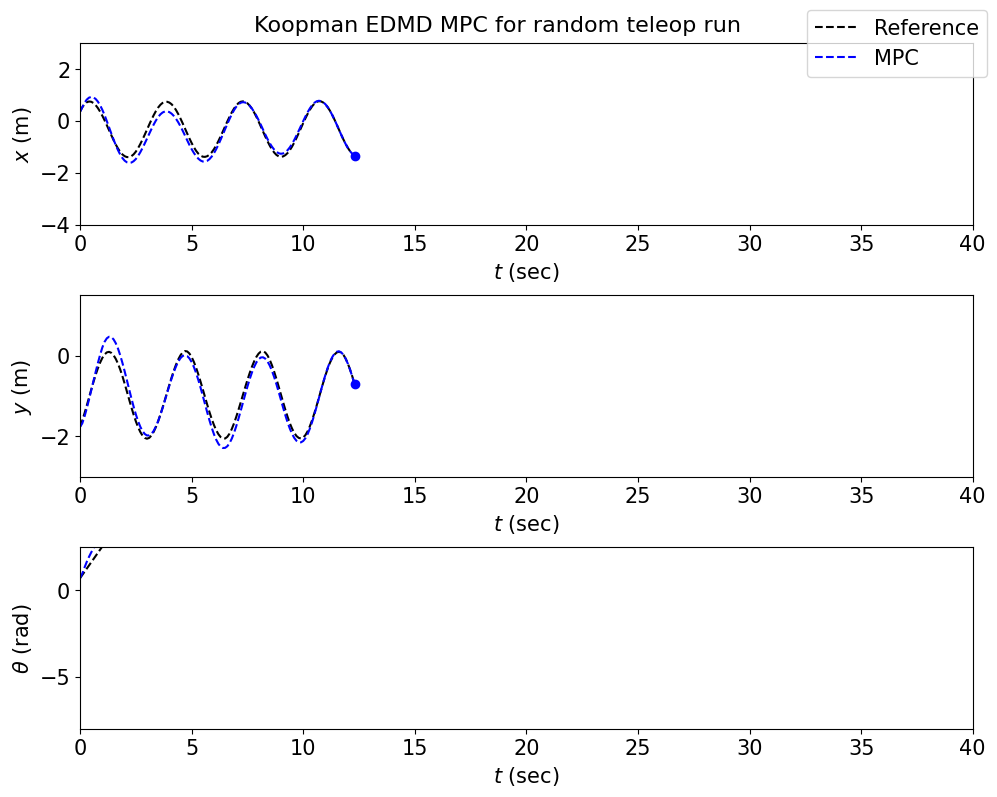

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# This needs to be changed for your code
plt.rcParams['animation.ffmpeg_path'] = 'D:\Koopman_F1tenth\\ffmpeg\\bin\\ffmpeg.exe'

# This is the final example I showed in the code - notice I have 2 "cursor marks" not shown in the video
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(10, 8))
axs[0].plot(x_ts,X_test[num[0]][:-N,0],'--k', label='x_ref')
axs[1].plot(x_ts,X_test[num[0]][:-N,1],'--k', label='y_ref')
axs[2].plot(x_ts,X_test[num[0]][:-N,3],'--k', label='theta_ref')
l, = axs[0].plot([], [], 'b--')
l2, = axs[1].plot([], [], 'b--')
l3, = axs[2].plot([], [], 'b--')
p1, = axs[0].plot([], [], 'bo')
p2, = axs[1].plot([], [], 'bo')
p3, = axs[2].plot([], [], 'bo')
axs[0].set(ylabel=r'$x$ (m)',xlabel=r'$t$ (sec)')
axs[1].set(ylabel=r'$y$ (m)',xlabel=r'$t$ (sec)')
axs[2].set(ylabel=r'$\theta$ (rad)',xlabel=r'$t$ (sec)')
axs[0].axis(xmin=0,xmax=40)
axs[0].axis(ymin=-4,ymax=3)
axs[1].axis(xmin=0,xmax=40)
axs[1].axis(ymin=-3,ymax=1.5)
axs[2].axis(xmin=0,xmax=40)
axs[2].axis(ymin=-8,ymax=2.5)
fig.legend(['Reference', 'MPC'],loc='upper right')
fig.suptitle('Koopman EDMD MPC for random teleop run', fontsize=16)

def func(x):
    return np.sin(x)*3

def func2(x):
    return np.cos(x)*3

metadata = dict(title='Movie', artist='codinglikemad')
writer = FFMpegWriter(fps=15, metadata=metadata)

xlist = []
ylist = []
ylist2 = []
ylist3 = []


with writer.saving(fig, "EDMD_Koopman_MPC_teleop.mp4", 250):
    # Plot the first line and cursor
    for i in range(len(x_ts)):
        xlist.append(x_ts[i])
        ylist.append(z_init[1,i])
        l.set_data(xlist,ylist)
        p1.set_data(x_ts[i],z_init[1,i])

        # xlist.append(x_ts[i])
        ylist2.append(z_init[2,i])
        l2.set_data(xlist,ylist2)
        p2.set_data(x_ts[i],z_init[2,i])

        # xlist3.append(x_ts[i])
        ylist3.append(z_init[4,i])
        l3.set_data(xlist,ylist3)
        p3.set_data(x_ts[i],z_init[4,i])

        writer.grab_frame()